<a href="https://colab.research.google.com/github/IzumiSatoshi/deforumed-walk/blob/main/notebooks/deforum_walk_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers accelerate
!pip install -q numpngw timm einops
!pip install -q git+https://github.com/huggingface/transformers 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.8 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/IzumiSatoshi/deforumed-walk.git

Cloning into 'deforumed-walk'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 119 (delta 51), reused 86 (delta 28), pack-reused 0
Receiving objects: 100% (119/119), 7.05 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
%cd deforumed-walk/

/content/deforumed-walk


In [4]:
import sys
sys.path.append("/content/deforumed-walk/src")
from warp import AnimArgs
from depth import DepthModel
import torch
import math
import py3d_tools as p3d
from einops import rearrange
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from diffusers import StableDiffusionPipeline, StableDiffusionDepth2ImgPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler, DDIMScheduler, EulerAncestralDiscreteScheduler
from IPython import display
import time
from diffusers import DiffusionPipeline 
import torch 
import os

In [6]:
# cuz I'm rich

pipe = DiffusionPipeline.from_pretrained(
    "/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1",
    custom_pipeline="lpw_stable_diffusion",
    torch_dtype=torch.float16,
).to("cuda")
d2i_pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "/content/drive/MyDrive/models/diffusers/sd_depth2img_fp16",
    torch_dtype=torch.float16,
).to("cuda")

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

In [7]:
depth_model = DepthModel(torch.device("cuda"), "/content/drive/MyDrive/AI/models/dpt_large-midas-2f21e586.pt", half_precision=True)

In [101]:
device = torch.device("cuda")

def controller(input_key):
    move_amount = 0.1
    rotate_amount = np.deg2rad(1)

    translate_xyz = [0, 0, 0]
    rotate_xyz = [0, 0, 0]
    if input_key == "w":    
        # move forward
        translate_xyz = [0, 0, -move_amount]
        rotate_xyz = [0, 0, 0]
    elif input_key == "a":
        # move left
        translate_xyz = [move_amount, 0, 0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "d":
        # move right
        translate_xyz = [-move_amount, 0, 0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "s":
        # move backward
        translate_xyz = [0, 0, -move_amount]
        rotate_xyz = [0, 0, 0]
    elif input_key == "t":
        # move up
        translate_xyz = [0, move_amount,0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "g":
        # move down
        translate_xyz = [0, -move_amount,0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "q":
        # rotate left
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, -rotate_amount, 0]
    elif input_key == "e":
        # rotate right
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, rotate_amount, 0]
    elif input_key == "r":
        # look up
        translate_xyz = [0, 0, 0]
        rotate_xyz = [rotate_amount, 0, 0]
    elif input_key == "f":
        # look down
        translate_xyz = [0, 0, 0]
        rotate_xyz = [rotate_amount, 0, 0]
    elif input_key == "z":
        # rotate clockwise
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, 0, -rotate_amount]
    elif input_key == "x":
        # rotate countercolockwise
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, 0, rotate_amount]

    return translate_xyz, rotate_xyz

def transform_prev_img(prev_img: PIL.Image, prev_depth: torch.Tensor,translate_xyz, rotate_xyz, device) -> PIL.Image:
    near=200,
    far=10_000,
    fov_deg=90,
    padding_mode="border"
    sampling_mode="bicubic"

    frame_idx = 0
    prev_img_numpy = np.array(prev_img)

    # x -> look up
    # y -> look right
    # z -> counterclockwise
    rot_mat = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz, device=device),
        "XYZ"
     ).unsqueeze(0)
    
    # transform_image_3d
    torch.cuda.empty_cache()

    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
    w, h = prev_img_numpy.shape[1], prev_img_numpy.shape[0]
    aspect_ratio = float(w) / float(h)
    persp_cam_old = p3d.FoVPerspectiveCameras(
        near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
    )
    persp_cam_new = p3d.FoVPerspectiveCameras(
        near,
        far,
        aspect_ratio,
        fov=fov_deg,
        degrees=True,
        R=rot_mat,
        T=torch.tensor([translate_xyz]),
        device=device,
    )
    # range of [-1,1] is important to torch grid_sample's padding handling
    y, x = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
        torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
    )
    if prev_depth is None:
        z = torch.ones_like(x)
    else:
        z = torch.as_tensor(prev_depth, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor(
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
    ).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(
        identity_2d_batch, [1, 1, h, w], align_corners=False
    )
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)
    image_tensor = rearrange(
        torch.from_numpy(prev_img_numpy.astype(np.float32)), "h w c -> c h w"
    ).to(device)

    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=sampling_mode,
        padding_mode=padding_mode,
        align_corners=False,
    )

    new_image = (
        rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
        .cpu()
        .numpy()
        .astype(prev_img_numpy.dtype)
    )
    new_image = PIL.Image.fromarray(new_image)

    return new_image
def normalize_dsd_depth(dsd_depth):
    depth_norm = dsd_depth - dsd_depth.min()
    depth_norm = depth_norm / depth_norm.max()
    depth_norm = depth_norm

    return depth_norm

In [12]:
def save_pil(img:PIL.Image, folder_path, index):
    os.makedirs(folder_path, exist_ok=True)
    img.save(f"{folder_path}/{str(index).zfill(4)}.png")

In [148]:
prompt = "photographs taken while walking through the streets of Paris, POV, travel vlog, 4k, high quality, sharp focus"
negative_prompt = "low quality, low resolution, blurry, black and white, bokeh"

strenght = 0.6
steps = 50
seed = 3
scheduler = DDIMScheduler

pipe.scheduler = scheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1/scheduler")
d2i_pipe.scheduler = scheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/sd_depth2img_fp16/scheduler")

  0%|          | 0/50 [00:00<?, ?it/s]

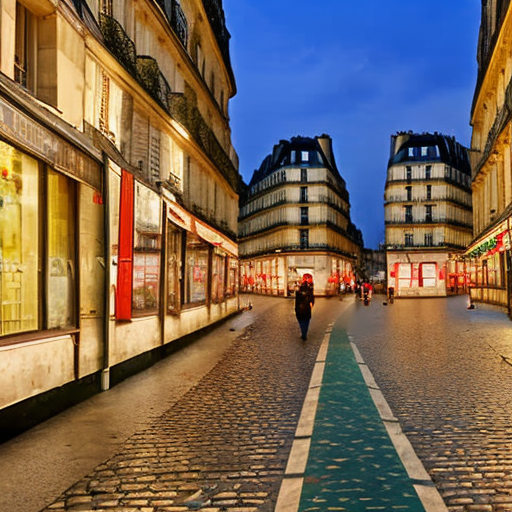

In [149]:
torch.manual_seed(seed)
init_img = pipe.text2img(
    prompt = prompt,
    negative_prompt = negative_prompt,
    num_inference_steps = steps,
).images[0]
init_img

In [154]:
def display_game(img, depth_tensor, suptitle):
    depth_norm = normalize_dsd_depth(depth_tensor)
    depth_norm = depth_norm.detach().cpu().numpy()
    depth_pil = PIL.Image.fromarray((depth_norm*255).astype(np.uint8))

    fig, axs = plt.subplots(1, 2, figsize=(26,13))
    axs[0].imshow(img)
    axs[0].set_title("player view", fontsize=20)
    axs[1].imshow(depth_pil, cmap="gray")
    axs[1].set_title("estimated depth map", fontsize=20)
    
    fig.suptitle(suptitle, fontsize=20)
    plt.show()

In [103]:
depth_tensor = depth_model.predict(init_img)

In [ ]:
second_img = PIL.Image.open("/content/drive/MyDrive/Project/deforumed_walk/girl.png")
display_game(init_img, depth_tensor)
display.clear_output(wait=True)
display_game(second_img, depth_tensor)

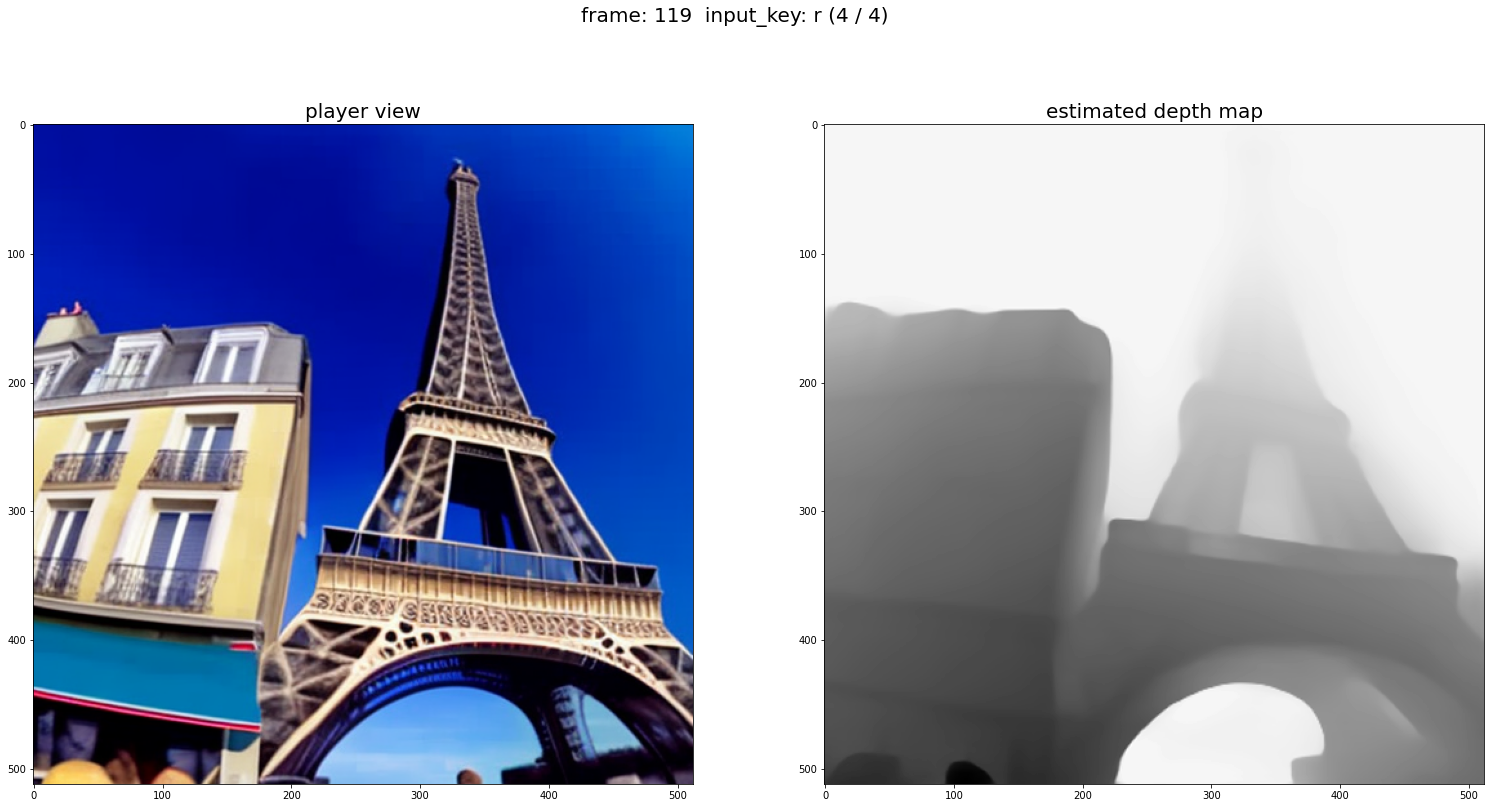

In [ ]:
folder_path = "/content/drive/MyDrive/Project/deforumed_walk/walk_in_paris"
save_pil(init_img, folder_path, 0) 

# display.display(init_img)


i = 1
prev_img = init_img
while True:
    input_keys = input(f"{i}: keybord inputs = ")
    for key_idx, input_key in enumerate(input_keys):
        if input_key == "h":
            next_img = d2i_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt, 
                image=transformed_prev_img, 
                depth_map=None,
                strength=0.9,
                num_inference_steps = steps,
            ).images[0]
        else:
            t,r = controller(input_key)
        
            prev_depth = depth_model.predict(prev_img)
            transformed_prev_img = transform_prev_img(prev_img, prev_depth, t, r, device)
            
            
            next_img = d2i_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt, 
                image=transformed_prev_img, 
                depth_map=None,
                strength=strenght,
                num_inference_steps = steps,
            ).images[0]
    
        save_pil(prev_img, folder_path, i)
        display.clear_output(wait=True)
        display_game(next_img, prev_depth, f"frame: {i}  input_key: {input_key} ({key_idx+1} / {len(input_keys)})")

        prev_img = next_img
        i += 1

In [ ]:
!echo $folder_path/hoge

/content/drive/MyDrive/Project/deforumed_walk/rotate_tower/hoge


In [ ]:
import glob 
paths = glob.glob(f"{folder_path}/*.png")

CLIP_FPS = 2
filepath = "/content/drive/MyDrive/Project/deforumed_walk/out.mp4"
codec = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(filepath, codec, CLIP_FPS, (512,512))

for img_file in paths:
    img = cv2.imread(img_file)
    video.write(img)

video.release()